# RR Lyrae Period-Luminosity

Eric Bellm
January 2022

In this exercise we'll use real data from a variety of surveys to learn more about the relationship between an RR Lyrae variable's period and its luminosity.

In [6]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle

sns.set_style("darkgrid")

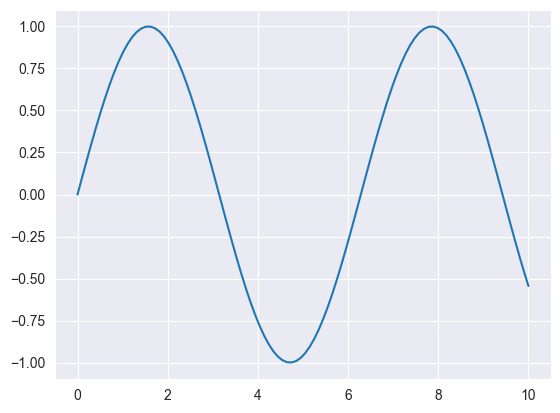

In [7]:
# plot some test data
x = np.linspace(0, 10, 100)
y = np.sin(x)
plt.plot(x, y)
plt.show()

## 1. Finding the Period of an RR Lyrae star

We begin by loading the ZTF lightcurve of a previously-identified RR Lyrae star.  We've pre-written this function for you.

In [8]:
def load_ztf_lc(filename):
    """Load a ZTF parquet lightcurve saved by `ztf_query`.

    See `ZTF_RRLyrae_data.ipynb` for data retrieval.

    Parameters
    ----------
    filename : string
        path to a parquet file saved by `ztf_query`

    Returns
    -------
    tbl : `astropy.timeseries.TimeSeries`
        lightcurve
    mean_ra : `float`
        mean right ascension of the source
    mean_dec : `float`
        mean declination of the source
    """

    #     tbl = Table.read(filename, format='parquet')
    tbl = pd.read_parquet(filename)

    # exclude flagged (bad) data
    tbl = tbl[tbl["catflags"] == 0]

    # compute average position for this source
    mean_ra = np.mean(tbl["ra"])
    mean_dec = np.mean(tbl["dec"])

    return (
        TimeSeries(
            time=Time(tbl["hjd"].values, format="jd"),
            data=Table.from_pandas(tbl[["mag", "magerr", "filtercode"]]),
        ),
        mean_ra,
        mean_dec,
    )

We load it into an astropy [`Timeseries`](https://docs.astropy.org/en/stable/timeseries/index.html).

In [9]:
ts, mean_ra, mean_dec = load_ztf_lc('./data/12.parquet')
ts

time,mag,magerr,filtercode
Time,float64,float64,str2
2458203.8852543235,17.1999512,0.0184876267,zg
2458203.9138199687,17.1843719,0.0183547549,zg
2458204.916476126,17.0556793,0.0173353087,zg
2458204.9394050865,17.0869713,0.0175707769,zg
2458204.959220457,17.113905,0.0177796986,zg
2458204.964672015,17.089777,0.0175922625,zg
2458204.965586341,17.0833168,0.0175428726,zg
2458204.999013193,17.1397419,0.0179857016,zg
2458204.999927622,17.1245728,0.0178640857,zg


In [10]:
print(mean_ra, mean_dec)

245.55715820833677 44.55899377304023


Which filters are present?

In [11]:
set(ts['filtercode'])
# this means {ZTF g-band, ZTF r-band, ZTF i-band}

{'zg', 'zi', 'zr'}

Let's assign default colors to these filters... you can change them if you like!

In [49]:
colors = {'zg':'C0',
          'zr':'C1',
          'zi':'C3'}

Next, let's plot the lightcurve.

In [28]:
def plot_lc(ts):
    """Plot a ZTF lightcurve.

    Parameters
    ----------
    ts :  `astropy.timeseries.TimeSeries`
        ZTF lightcurve

    """

    plt.figure()

    # loop over the available filters
    for filt in set(ts["filtercode"]):
        # select the rows that correspond to that filter
        wfilt = ts["filtercode"] == filt
        plt.errorbar(
            ts[wfilt].time.mjd,
            ts[wfilt]["mag"],
            ts[wfilt]["magerr"],
            label=filt,
            fmt=".",
            ls="none",
            color=colors[filt],
            alpha=0.6,
        )

    plt.legend()
    plt.xlabel("MJD (days)")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()  # smaller magnitudes are brighter--flip the y axis!

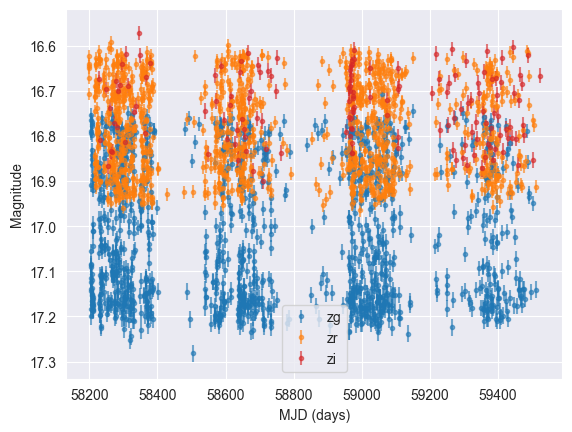

In [29]:
plot_lc(ts)

Astropy's period finding expects the inputs to be in a single filter.  

Let's define a selector that identifies only the rows with r-band data:

In [15]:
wr = ts['filtercode'] == 'zr'

Here's an example of how to apply it:

In [33]:
ts[wr]

time,mag,magerr,filtercode
Time,float64,float64,str2
2458198.8946163347,16.6217289,0.0131340921,zr
2458198.901422055,16.6403427,0.013216096,zr
2458198.930369789,16.6501369,0.0132599398,zr
2458198.953194622,16.6455307,0.0132392608,zr
2458198.9775009,16.6713829,0.0133567192,zr
2458198.985267348,16.7065659,0.0135220876,zr
2458216.877874348,16.7450008,0.0137102464,zr
2458216.8980251774,16.7125301,0.0135507695,zr
2458216.8999234224,16.7105103,0.0135410335,zr


### Exercise 1 Tasks:

* Compute the Lomb-Scargle periodogram for the r-band lightcurve using the astropy [`LombScargle`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) class.
* Plot the resulting periodogram (frequency, power) or (period, power).  Label your axes.
* Identify the "best" period from the periodogram (highest peak)
* Plot the phase-folded lightcurve (in all 3 filters) for this period.
    * HINT: you can compute phase as `phase = (time % P)/P`

In [34]:
r_band_data = ts[wr]

Text(0, 0.5, 'Lomb Scargle Power')

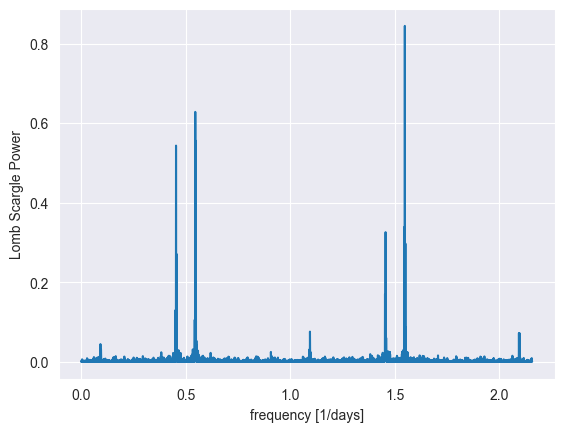

In [36]:
time = r_band_data["time"]
mag = r_band_data["mag"]
error = r_band_data["magerr"]

plt.figure()

freq, power = LombScargle(time, mag, error).autopower()

plt.plot(freq, power)
plt.xlabel("frequency [1/days]")
plt.ylabel("Lomb Scargle Power")

In [37]:
best_freq = freq[np.argmax(power)]
print(f"The best frequency is {best_freq}")

The best frequency is 1.5487984907364891 1 / d


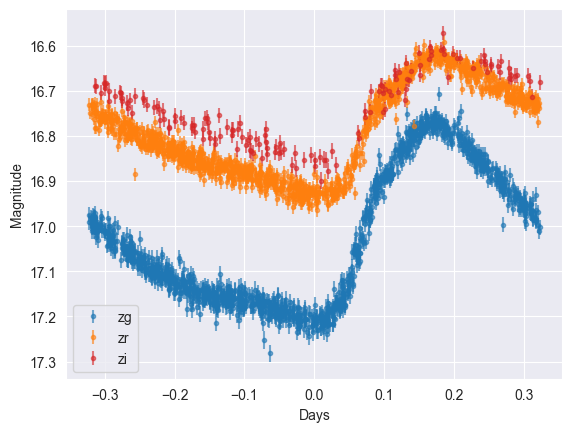

In [50]:
# Plot the folded light curve for each filter
ts_folded = ts.fold(1 / best_freq)

plt.figure()

# loop over the available filters
for filter_code in set(ts_folded["filtercode"]):
    # select the rows that correspond to that filter
    fc_filter = ts["filtercode"] == filter_code
    plt.errorbar(
        ts_folded[fc_filter].time.jd,
        ts_folded[fc_filter]["mag"],
        ts_folded[fc_filter]["magerr"],
        label=filter_code,
        fmt=".",
        ls="none",
        color=colors[filter_code],
        alpha=0.6,
    )

plt.legend()
plt.xlabel("Days")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()  # smaller magnitudes are brighter--flip the y axis!

## 2. Plot Period-Luminosity relation

If we computed a large number of periods for RR Lyrae for which we knew their distances, we could determine if there is a relationship between period and luminosity, and use it for new stars we discover.  

Computing so many periods is a lot of work, so let's use a recently-published catalog from [Huang and Koposov 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.3575H/abstract).  We will read in their catalog directly from one of the provided files:

In [51]:
# read using astropy Tables

# tbl = Table.read('rrl_main_cat.csv.gz')
tbl = pd.read_csv('./data/rrl_main_cat.csv.gz')

In [52]:
tbl.columns

Index(['objid', 'source_id', 'ra', 'dec', 'prob_rrl', 'best_period', 'ebv',
       'distance', 'mean_g', 'mean_r', 'mean_i', 'phot_g_mean_mag', 'amp_1_r',
       'phi_1_r', 'amp_1_g', 'phi_1_g', 'amp_1_i', 'phi_1_i', 'amp_2_r',
       'phi_2_r', 'amp_2_g', 'phi_2_g', 'amp_2_i', 'phi_2_i', 'amp_3_r',
       'phi_3_r', 'amp_3_g', 'phi_3_g', 'amp_3_i', 'phi_3_i', 'ngooddet_g',
       'ngooddet_r', 'ngooddet_i'],
      dtype='object')

In [53]:
tbl

,objid,source_id,ra,dec,prob_rrl,best_period,ebv,distance,mean_g,mean_r,...,phi_2_i,amp_3_r,phi_3_r,amp_3_g,phi_3_g,amp_3_i,phi_3_i,ngooddet_g,ngooddet_r,ngooddet_i
0,245101100001850,2323207596351730304,4.348810,-26.732536,0.95,0.621282,0.017800,35202.50,18.448895,18.263773,...,NaN,0.077740,2.935552,0.111422,2.603256,NaN,NaN,74,76,0
1,245101200001823,2323151181956812672,3.447620,-26.736970,0.89,0.363568,0.022338,20908.60,17.662470,17.580330,...,NaN,0.029519,-1.650670,0.016883,-1.853666,NaN,NaN,80,81,0
2,245101200006240,2323082286386272640,3.835872,-27.043744,0.99,0.566281,0.021689,19608.20,17.265985,17.059336,...,NaN,0.085038,-0.778089,0.113630,-0.978785,NaN,NaN,79,79,0
3,245102200002148,2333889115592815616,1.835088,-26.738657,0.97,0.501806,0.019093,17462.70,17.080528,16.900640,...,NaN,0.110369,0.818376,0.183042,0.821719,NaN,NaN,82,80,0
4,245103100001517,2333944331692281728,0.885323,-26.598856,0.98,0.581180,0.015864,13775.10,16.477060,16.245916,...,NaN,0.058639,-2.562542,0.071819,-2.906403,NaN,NaN,82,84,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71750,1879208400011172,2272270834706465920,324.768594,71.044147,0.35,0.649538,1.258720,5755.82,NaN,17.113964,...,NaN,0.067484,2.683545,NaN,NaN,NaN,NaN,0,13,0
71751,1879209200004154,2231410027681772288,340.864367,74.372477,0.18,0.513566,0.499083,2867.72,NaN,14.039189,...,NaN,0.147617,1.148570,NaN,NaN,NaN,NaN,0,24,0
71752,1879215100000755,2280500266922334592,329.268712,76.556483,0.78,0.586766,1.026020,3491.94,NaN,15.570923,...,NaN,0.058478,-0.365135,NaN,NaN,NaN,NaN,0,13,0
71753,1879215200000500,2283493717393209088,327.082855,76.555306,0.25,0.524648,0.968454,6565.56,NaN,16.888970,...,NaN,0.054812,-1.874446,NaN,NaN,NaN,NaN,0,13,0


The catalog provides a probability that the stars they have selected are actually RR Lyrae.  Define a selector to only choose *high-confidence* RR Lyrae:

In [55]:
wgood_filter = tbl['prob_rrl'] > 0.95

### Exercise 2 Tasks:

    
* Compute the absolute r-band magnitude for the high-confidence RR Lyrae using the provided values of distance (in pc) and dust extinction E(B-V) (the `ebv` column).  
    * Use A_r = 2.27, so the extinction correction is $-2.27 \times E(B-V)$ in magnitudes
* Scatter plot the absolute magnitude versus catalog period (`best_period`).  Overplot the period-luminosity relation: $M_r = -1.6 \:\log_{10}(\frac{P}{0.6}) + 0.51$, where $P$ is the period in days.
    * HINT: There are some bad values, be sure to "zoom in" to see the majority of points
* That period-luminosity relationship is not a great fit--the distances in the table were derived from averages over all three ZTF bands.  Fit a new linear period-luminosity relationship to the high-confidence RR Lyrae ([`astropy.modeling`](https://docs.astropy.org/en/stable/modeling/index.html) or [`np.polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) may be helpful) and overplot it.  
    * HINT: Be sure that the `x` coordinate you fit is the log of the period: $\log_{10}(\frac{P}{0.6})$.

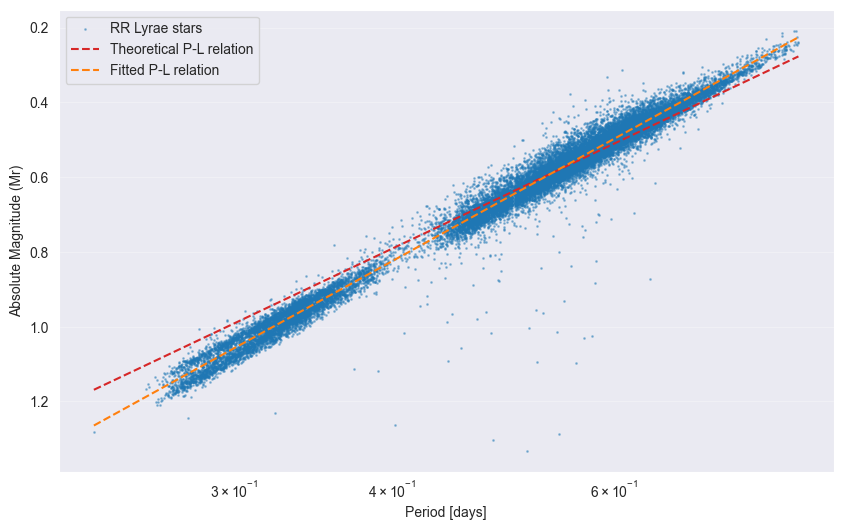

In [61]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Data processing classes following clean architecture principles
class RRLyraeDataProcessor:
    """Class to handle RR Lyrae data processing and cleaning"""

    def __init__(self, data):
        self.data = data

    def clean_and_filter(self, confidence_threshold=0.95):
        """
        Clean data by removing NaN values and filter for high confidence RR Lyrae stars
        Args:
            confidence_threshold: Minimum probability threshold for RR Lyrae classification
        Returns:
            Filtered DataFrame with high confidence RR Lyrae stars
        """
        clean_data = self.data.dropna(subset=["mean_r"])
        return clean_data[clean_data["prob_rrl"] > confidence_threshold]

    def calculate_absolute_magnitudes(self, filtered_data):
        """
        Calculate absolute magnitudes using the distance modulus equation and extinction correction
        M = m - 5log10(d) + 5 - A_r * E(B-V)
        where:
        - m is apparent magnitude
        - d is distance in parsecs
        - A_r = 2.27 is the extinction coefficient
        - E(B-V) is the color excess
        """
        return (
            filtered_data["mean_r"].values
            - 5 * np.log10(filtered_data["distance"].values)
            + 5
            - 2.27 * filtered_data["ebv"].values
        )


class PeriodLuminosityRelation:
    """Class to handle period-luminosity relationship calculations and fitting"""

    @staticmethod
    def theoretical_relation(periods):
        """Calculate theoretical P-L relation: M_r = -1.6 log10(P/0.6) + 0.51"""
        return -1.6 * np.log10(periods / 0.6) + 0.51

    @staticmethod
    def pl_model(x, a, b):
        return a * np.log10(x / 0.6) + b

    @staticmethod
    def fit_empirical_relation(periods, magnitudes):
        """
        Fit empirical P-L relation using curve_fit
        Model: M = a * log10(P/0.6) + b
        """

        fitted_params, _ = curve_fit(
            PeriodLuminosityRelation.pl_model, periods, magnitudes
        )
        return PeriodLuminosityRelation.pl_model, fitted_params


class PLPlotter:
    """Class to handle plotting of period-luminosity relationships"""

    def __init__(self, periods, magnitudes):
        self.periods = periods
        self.magnitudes = magnitudes
        self.fig = plt.figure(figsize=(10, 6))

    def plot_data_points(self):
        """Plot individual RR Lyrae stars"""
        plt.scatter(
            self.periods,
            self.magnitudes,
            s=1,
            alpha=0.4,
            label="RR Lyrae stars",
            c="tab:blue",
        )

    def plot_relations(self, plot_periods, theoretical_mags, fitted_mags):
        """Plot theoretical and fitted P-L relations"""
        plt.plot(
            plot_periods,
            theoretical_mags,
            color="tab:red",
            ls="--",
            label="Theoretical P-L relation",
        )
        plt.plot(
            plot_periods,
            fitted_mags,
            color="tab:orange",
            ls="--",
            label="Fitted P-L relation",
        )

    def configure_plot(self):
        """Configure plot aesthetics and labels"""
        plt.gca().invert_yaxis()  # Magnitudes decrease upward
        plt.semilogx()  # Log scale for period
        plt.xlabel("Period [days]")
        plt.ylabel("Absolute Magnitude (Mr)")
        plt.legend()
        plt.grid(True, alpha=0.3)


# Main execution flow
# Process and clean data
processor = RRLyraeDataProcessor(tbl)
high_conf_data = processor.clean_and_filter()
abs_mags = processor.calculate_absolute_magnitudes(high_conf_data)
periods = high_conf_data["best_period"].values

# Calculate P-L relations
pl_relation = PeriodLuminosityRelation()
plot_periods = np.linspace(min(periods), max(periods), 100)
theoretical_mags = pl_relation.theoretical_relation(plot_periods)
pl_model, fitted_params = pl_relation.fit_empirical_relation(periods, abs_mags)
fitted_mags = pl_model(plot_periods, *fitted_params)

# Create and show plot
plotter = PLPlotter(periods, abs_mags)
plotter.plot_data_points()
plotter.plot_relations(plot_periods, theoretical_mags, fitted_mags)
plotter.configure_plot()
plt.show()

## 3. Estimate distance from the Period-Luminosity relation.

Now let's compute the distance our period-luminosity relationship implies for the RR Lyrae in exercise 1.

We will need the E(B-V) value at the source location, which we are providing you:

**E(B-V) = 0.012 mag**

In [73]:
ztf_src_ebv = 0.012

But you *could* programatically get it like this:

In [4]:
# from astroquery.ipac.irsa.irsa_dust import IrsaDust
# from astropy.coordinates import SkyCoord

# ztf_src_sc = SkyCoord(mean_ra, mean_dec, unit='degree')

# ztf_src_ebv = IrsaDust.get_query_table(ztf_src_sc,section='ebv')['ext SFD mean'].value[0]
# ztf_src_ebv

For this exercise:

* Use the period-luminosity relationship and the best-fit period of the source from Exercise 1 to **estimate the  distance in parsecs to our RR Lyr star.**

In [ ]:
period = 1 / best_freq.value

# Use fitted parameters to calculate absolute magnitude from period
# pl_model implements the relationship: M = a * log10(P) + b
# where a and b are the fitted parameters
absol_mag = PeriodLuminosityRelation.pl_model(
    period,
    fitted_params[0],  # a parameter
    fitted_params[1],  # b parameter
)


# Next use the distance modulus to calculate the distance to the star 
# using the mean_r magnitude: d = 10**((M - m - 5 + A)/-5)
mean_r = np.mean(r_band_data["mag"])
d = 10 ** ((absol_mag - mean_r - 5 + 2.27 * ztf_src_ebv) / -5)
print(f"The distance is {d:0.2f} parsecs")


The distance is 18391.45 parsecs
